In [ ]:
import numpy as np

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Data Loading 

In [ ]:
# Useful Constants
# Output classes to learn how to classify
LABELS = [    
    "JUMPING",
    "JUMPING_JACKS",
    "BOXING",
    "WAVING_2HANDS",
    "WAVING_1HAND",
    "CLAPPING_HANDS"

] 
DATASET_PATH = "drive/MyDrive/CACM/repo/data/database/"

X_train_path = DATASET_PATH + "X_train.txt"
X_test_path = DATASET_PATH + "X_test.txt"

y_train_path = DATASET_PATH + "Y_train.txt"
y_test_path = DATASET_PATH + "Y_test.txt"

n_steps = 32 # 32 timesteps per series
n_categories = len(LABELS)

In [ ]:
# Load the networks inputs

def load_X(X_path):
    file = open(X_path, 'r')
    X_ = np.array(
        [elem for elem in [
            row.split(',') for row in file
        ]], 
        dtype=np.float32
    )
    file.close()
    blocks = int(len(X_) / n_steps)
    
    X_ = np.array(np.split(X_,blocks))

    return X_ 

# Load the networks outputs
def load_y(y_path):
    file = open(y_path, 'r')
    y_ = np.array(
        [elem for elem in [
            row.replace('  ', ' ').strip().split(' ') for row in file
        ]], 
        dtype=np.int32
    )
    file.close()
    
    # for 0-based indexing 
    return y_ - 1

X_train = load_X(X_train_path)
X_test = load_X(X_test_path)

y_train = load_y(y_train_path)
y_test = load_y(y_test_path)

In [ ]:
X_train.shape

(22625, 32, 36)

data visual

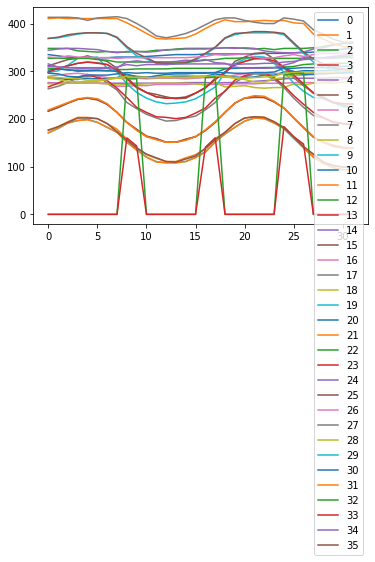

In [ ]:
y_train[1]
y_train[2]

tensor([0], dtype=torch.int32)

### Pre-Process 

In [ ]:
import torch

In [ ]:
tensor_X_test = torch.from_numpy(X_test)
print('test_data_size:',tensor_X_test.size())
tensor_y_test = torch.from_numpy(y_test)
print('test_label_size:',tensor_y_test.size())
n_data_size_test = tensor_X_test.size()[0]
print('n_data_size_test:',n_data_size_test)

tensor_X_train = torch.from_numpy(X_train)
print('train_data_size:',tensor_X_train.size())
tensor_y_train = torch.from_numpy(y_train)
print('train_label_size:',tensor_y_train.size())
n_data_size_train = tensor_X_train.size()[0]
print('n_data_size_train:',n_data_size_train)

test_data_size: torch.Size([5751, 32, 36])
test_label_size: torch.Size([5751, 1])
n_data_size_test: 5751
train_data_size: torch.Size([22625, 32, 36])
train_label_size: torch.Size([22625, 1])
n_data_size_train: 22625


In [ ]:
import torch.nn as nn

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [32]:
class LSTM(nn.Module):
    
    def __init__(self,input_dim,hidden_dim,output_dim,layer_num):
        super(LSTM,self).__init__()
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        self.lstm = torch.nn.LSTM(input_dim,hidden_dim,layer_num,batch_first=True)
        self.fc = torch.nn.Linear(hidden_dim,output_dim)
        self.bn = nn.BatchNorm1d(32)
        
    def forward(self,inputs):
        x = self.bn(inputs)
        lstm_out,(hn,cn) = self.lstm(x)
        out = self.fc(lstm_out[:,-1,:])
        return out

In [33]:
n_hidden = 128
n_joints = 18*2
n_categories = 6
n_layer = 3
rnn = LSTM(n_joints,n_hidden,n_categories,n_layer)
rnn.to(device)

LSTM(
  (lstm): LSTM(36, 128, num_layers=3, batch_first=True)
  (fc): Linear(in_features=128, out_features=6, bias=True)
  (bn): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

In [29]:
def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return LABELS[category_i], category_i

### Getting Random Data 

In [28]:
import random
def randomTrainingExampleBatch(batch_size,flag,num=-1):
    if flag == 'train':
        X = tensor_X_train
        y = tensor_y_train
        data_size = n_data_size_train
    elif flag == 'test':
        X = tensor_X_test
        y = tensor_y_test
        data_size = n_data_size_test
    if num == -1:
        ran_num = random.randint(0,data_size-batch_size)
    else:
        ran_num = num
    pose_sequence_tensor = X[ran_num:(ran_num+batch_size)]
    pose_sequence_tensor = pose_sequence_tensor
    category_tensor = y[ran_num:ran_num+batch_size,:]
    return category_tensor.long(),pose_sequence_tensor

### Training

In [35]:
try:
   rnn.load_state_dict(torch.load('drive/MyDrive/CACM/repo/lstm_6_bn.pth'))
except:
   print('no pkl')

In [36]:
import torch.optim as optim
import time
import math

criterion = nn.CrossEntropyLoss()
learning_rate = 0.0005
optimizer = optim.SGD(rnn.parameters(),lr=learning_rate,momentum=0.9)
#scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10000, gamma=0.1)

n_iters = 100000
#n_iters = 60000
print_every = 1000
plot_every = 1000
batch_size = 128

# Keep track of losses for plotting
current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
   
    category_tensor, input_sequence = randomTrainingExampleBatch(batch_size,'train')
    input_sequence = input_sequence.to(device)
    category_tensor = category_tensor.to(device)
    category_tensor = torch.squeeze(category_tensor)
    
    optimizer.zero_grad()
    
    output = rnn(input_sequence)
    loss = criterion(output, category_tensor)
    loss.backward()
    optimizer.step() 
    #scheduler.step()
    
    #如果tensor只有一个元素,那么可以用.item()的方法取出这个元素作为普通的python数字.
    current_loss += loss.item()
    
    category = LABELS[int(category_tensor[0])]

    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f  / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, guess, correct))
        
    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

1000 1% (0m 7s) 0.0011  / JUMPING_JACKS ✓
2000 2% (0m 14s) 0.0003  / WAVING_1HAND ✓
3000 3% (0m 20s) 0.2595  / BOXING ✓
4000 4% (0m 26s) 0.0024  / WAVING_2HANDS ✓
5000 5% (0m 33s) 0.0060  / WAVING_2HANDS ✓
6000 6% (0m 39s) 0.0003  / WAVING_1HAND ✓
7000 7% (0m 46s) 0.0019  / WAVING_2HANDS ✓
8000 8% (0m 53s) 0.0014  / JUMPING_JACKS ✓
9000 9% (0m 59s) 0.0069  / BOXING ✓
10000 10% (1m 6s) 0.0007  / JUMPING ✓
11000 11% (1m 12s) 0.0014  / JUMPING_JACKS ✓
12000 12% (1m 19s) 0.0002  / WAVING_1HAND ✓
13000 13% (1m 25s) 0.0023  / BOXING ✓
14000 14% (1m 32s) 0.0010  / WAVING_2HANDS ✓
15000 15% (1m 39s) 0.3825  / CLAPPING_HANDS ✓
16000 16% (1m 45s) 0.0986  / BOXING ✓
17000 17% (1m 52s) 0.0021  / BOXING ✓
18000 18% (1m 59s) 0.0039  / BOXING ✓
19000 19% (2m 5s) 0.1207  / BOXING ✓
20000 20% (2m 12s) 0.0007  / BOXING ✓
21000 21% (2m 18s) 0.0002  / WAVING_1HAND ✓
22000 22% (2m 25s) 0.0017  / JUMPING_JACKS ✓
23000 23% (2m 32s) 0.0071  / BOXING ✓
24000 24% (2m 39s) 0.0018  / WAVING_2HANDS ✓
25000 25% (2m

KeyboardInterrupt: ignored

In [ ]:
torch.save(rnn.state_dict(),'lstm_6_bn.pkl')

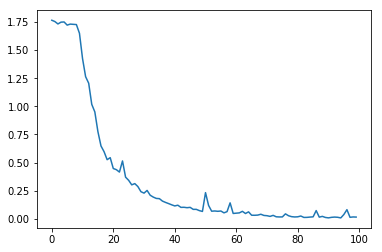

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)

### Testing

In [153]:
def test(flag):
    if flag == 'train':
        n = n_data_size_train
    elif flag == 'test':
        n = n_data_size_test   
        
    with torch.no_grad():
        right = 0
        for i in range(n):
            category_tensor, inputs = randomTrainingExampleBatch(1,flag,i)
            category = LABELS[int(category_tensor[0])]
            inputs = inputs.to(device)
            output = rnn(inputs)
            guess, guess_i = categoryFromOutput(output)
            category_i = LABELS.index(category)
            if category_i == guess_i:
                right+=1
    print(flag,'accuracy',right/n)
    return right/n

In [154]:
test('test')

test accuracy 0.9721787515214745


0.9721787515214745

In [ ]:
test('train')

train accuracy 0.9888618784530386


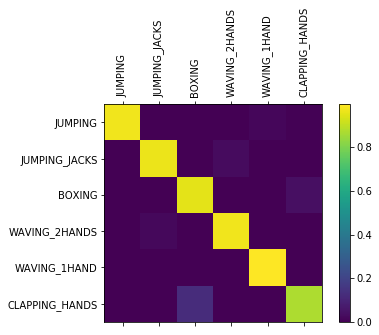

In [ ]:
# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(n_categories, n_categories)
n_confusion = n_data_size_test

# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    category_tensor, inputs = randomTrainingExampleBatch(1,'test',i)
    category = LABELS[int(category_tensor[0])]
    inputs = inputs.to(device)
    output = rnn(inputs)
    guess, guess_i = categoryFromOutput(output)
    category_i = LABELS.index(category)
    confusion[category_i][guess_i] += 1
     
# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + LABELS, rotation=90)
ax.set_yticklabels([''] + LABELS)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

 Computing LSTM feature importance...


  0%|          | 0/36 [00:00<?, ?it/s]

test accuracy 0.9080159972178752
test accuracy 0.9104503564597461
test accuracy 0.8555033907146583
test accuracy 0.9069727003999305
test accuracy 0.9027995131281517
test accuracy 0.9057555207789949
test accuracy 0.9031472787341331
test accuracy 0.9001912710832899
test accuracy 0.7668231611893583
test accuracy 0.8078595026951835
test accuracy 0.6666666666666666
test accuracy 0.9104503564597461
test accuracy 0.9012345679012346
test accuracy 0.898452443053382
test accuracy 0.8273343766301513
test accuracy 0.7899495739871327
test accuracy 0.5524256651017214
test accuracy 0.9038428099460963
test accuracy 0.904886106764041
test accuracy 0.8892366544948704
test accuracy 0.9059294035819857
test accuracy 0.866284124500087
test accuracy 0.901756216310207
test accuracy 0.9078421144148844
test accuracy 0.9031472787341331
test accuracy 0.9040166927490871
test accuracy 0.9087115284298383
test accuracy 0.8897583029038428
test accuracy 0.9036689271431055
test accuracy 0.8781081551034603
test accuracy 

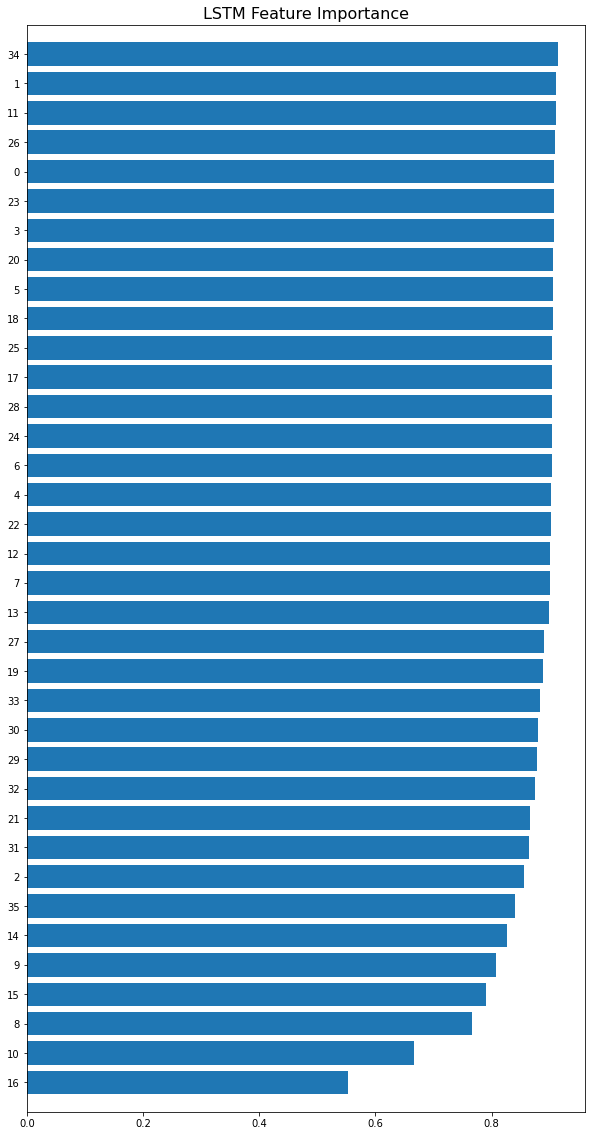

In [156]:

import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

import tensorflow as tf
from tensorflow import keras
import tensorflow.keras.backend as K
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.callbacks import LearningRateScheduler, ReduceLROnPlateau
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from sklearn.metrics import mean_absolute_error as mae
from sklearn.preprocessing import RobustScaler, normalize
from sklearn.model_selection import train_test_split, GroupKFold, KFold
from IPython.display import display


# GET GPU STRATEGY
gpu_strategy = tf.distribute.get_strategy()

EPOCH = 300
BATCH_SIZE = 1024
NUM_FOLDS = 10

COMPUTE_LSTM_IMPORTANCE = 1
ONE_FOLD_ONLY = 0

COLS = 36

with gpu_strategy.scope():
    kf = KFold(n_splits=NUM_FOLDS, shuffle=True, random_state=2021)
    test_preds = []
    # for fold, (train_idx, test_idx) in enumerate(kf.split(tensor_X_test, tensor_y_test)):
      
      
    #     K.clear_session()
        
    #     print('-'*15, '>', f'Fold {fold+1}', '<', '-'*15)
    #     X_train, X_valid = tensor_X_test[train_idx], tensor_X_test[test_idx]
    #     y_train, y_valid = tensor_y_test[train_idx], tensor_y_test[test_idx]
    # X_valid = tensor_X_test
    # y_valid = tensor_y_test
    # y_valid_list = y_valid.numpy().flatten().tolist()
    
    
    # 计算特征重要性
    if COMPUTE_LSTM_IMPORTANCE:
        results = []
        print(' Computing LSTM feature importance...')

        # for k in tqdm(range(len(COLS))):
        for k in tqdm(range(COLS)):
            if k>0: 
                temp = tensor_X_test.numpy()
                save_col = temp[:,:,k-1].copy()
                np.random.shuffle(temp[:,:,k-1])
                
                tensor_X_test = torch.from_numpy(temp)

            # cat = []
            # cat_i = []
            # for i in range(len(X_valid)):
            #   input_tensor = X_valid[i:i+1]
            #   input_tensor = input_tensor.to(device)
            #   output = rnn(input_tensor)
            #   guess, guess_i = categoryFromOutput(output) 
            #   cat.append(guess)
            #   cat_i.append(guess_i)        
            # oof_preds = rnn(X_valid).squeeze() 
            # mae = np.mean(np.abs( oof_preds-y_valid ))
            # print("after shuffle")
            # print(temp[:,:,k-1])
            
            # diff = set(y_valid_list).difference(set(cat_i))
            # mae = len(diff)
            mae = 1-test('test')
            # print(mae)
            results.append({'feature':k,'mae':mae})
    
            if k>0: 
                temp[:,:,k-1] = save_col
                tensor_X_test = torch.from_numpy(temp)
                # print("before shuffle")
                # print(temp[:,:,k-1])
                # X_valid[:,:,k-1] = save_col
      
        # 展示特征重要性
        print()
        df = pd.DataFrame(results)
        df = df.sort_values('mae')
        plt.figure(figsize=(10,20))
        plt.barh(np.arange(COLS),df.mae)
        plt.yticks(np.arange(COLS),df.feature.values)
        plt.title('LSTM Feature Importance',size=16)
        plt.ylim((-1,COLS))
        plt.show()
                               
            # # SAVE LSTM FEATURE IMPORTANCE
            # df = df.sort_values('mae',ascending=False)
            # df.to_csv(f'lstm_feature_importance_fold_{fold}.csv',index=False)
                               
        # # ONLY DO ONE FOLD
        # if ONE_FOLD_ONLY: break

In [157]:
df.to_csv(f'lstm_feature_importance.csv',index=False)